# Toy Schedules Generation

Generate a population (schedules and attributes). Where every schedule is home -> ACTIVITY -> home, with varying durations. Where ACTIVITY depends on work_status attribute.

In [9]:
from pathlib import Path

import pandas as pd
from numpy.random import choice
import random

from caveat.data.synth import ActivityGen
from caveat.data.utils import generate_population, trace_to_pam
from caveat.evaluate.describe.times import (
    joint_time_distributions_plot,
    times_distributions_plot,
)
from caveat.evaluate.describe.transitions import sequence_prob_plot

In [10]:
n = 10000
ps = {
    "employed": [0.8, 0.0, 0.2],
    "student": [0.2, 0.6, 0.2],
    "unemployed": [0.1, 0.1, 0.8],
}

schedules_write_path = Path("tmp/toy_noisy_schedules.csv")
attributes_write_path = Path("tmp/toy_noisy_attributes.csv")

In [20]:
pid = []
pids = []
acts = []
starts = []
ends = []
durations = []
work_statuses = []

for i in range(n):
    pid.append(i)
    work_status = random.choice(["employed", "student", "unemployed"])
    probs = ps
    activity = choice(["work", "education", "other"], p=probs[work_status])
    work_statuses.append(work_status)

    budget = 1440
    sequence = ["home"]
    seq_durations = []

    if activity in ["work", "education"]:
        departure_time = random.randint(400, 500)
    else:
        departure_time = random.randint(500, 800)
    seq_durations.append(departure_time)
    budget -= departure_time

    sequence.append(activity)
    if activity == "other":
        act_duration = random.randint(60, 180)
    elif activity == "work":
        act_duration = random.randint(400, 600)
    else:
        act_duration = random.randint(300, 500)
    seq_durations.append(act_duration)
    budget -= act_duration

    if budget > 600:
        sequence.append("home")
        home_duration = random.randint(60, 240)
        seq_durations.append(home_duration)
        budget -= home_duration
        sequence.append("other")
        act_duration = random.randint(60, 180)
        seq_durations.append(act_duration)
        budget -= act_duration

    sequence.append("home")
    seq_durations.append(budget)
    home_duration = budget

    t = 0
    for act, duration in zip(
        sequence,
        seq_durations,
    ):
        pids.append(i)
        acts.append(act)
        starts.append(t)
        t += duration
        ends.append(t)
        durations.append(duration)

schedules = pd.DataFrame(
    {
        "pid": pids,
        "act": acts,
        "start": starts,
        "end": ends,
        "duration": durations,
    }
)

attributes = pd.DataFrame(
    {
        "pid": pid,
        "work_status": work_statuses,
    }
)

print(schedules.head(20))
print(attributes.head())

    pid        act  start   end  duration
0     0       home      0   669       669
1     0      other    669   803       134
2     0       home    803  1009       206
3     0      other   1009  1101        92
4     0       home   1101  1440       339
5     1       home      0   464       464
6     1  education    464   869       405
7     1       home    869  1440       571
8     2       home      0   581       581
9     2      other    581   645        64
10    2       home    645   786       141
11    2      other    786   942       156
12    2       home    942  1440       498
13    3       home      0   737       737
14    3      other    737   909       172
15    3       home    909  1440       531
16    4       home      0   459       459
17    4       work    459   927       468
18    4       home    927  1440       513
19    5       home      0   460       460
   pid work_status
0    0     student
1    1     student
2    2  unemployed
3    3  unemployed
4    4  unemployed


In [21]:
schedules_write_path.parent.mkdir(exist_ok=True)
attributes_write_path.parent.mkdir(exist_ok=True)
schedules.to_csv(schedules_write_path, index=False)
attributes.to_csv(attributes_write_path, index=False)

In [22]:
def describe_col(population, col: str) -> pd.DataFrame:
    description = population.groupby("act")[col].describe()[
        ["count", "mean", "std", "min", "max"]
    ]
    description["attribute"] = col
    return description


def describe_cols(population, cols: list[str]) -> pd.DataFrame:
    description = pd.concat(
        [describe_col(population, c) for c in cols], ignore_index=False
    )
    description = description.reset_index().set_index(["attribute", "act"])
    return description


describe_cols(schedules, ["start", "end", "duration"]).round()

count   mean    std    min     max
attribute act                                            
start     education   2336.0  450.0   29.0  400.0   500.0
          home       24118.0  527.0  454.0    0.0  1242.0
          other       8124.0  773.0  151.0  500.0  1078.0
          work        3658.0  450.0   29.0  400.0   500.0
end       education   2336.0  850.0   64.0  705.0   993.0
          home       24118.0  969.0  424.0  400.0  1440.0
          other       8124.0  893.0  155.0  560.0  1242.0
          work        3658.0  949.0   64.0  801.0  1099.0
duration  education   2336.0  400.0   59.0  300.0   500.0
          home       24118.0  442.0  165.0   60.0   800.0
          other       8124.0  119.0   35.0   60.0   180.0
          work        3658.0  499.0   58.0  400.0   600.0

In [23]:
def time_distributions(population: pd.DataFrame, mapping: dict):
    starts = {k: [] for k in mapping.values()}
    ends = {k: [] for k in mapping.values()}
    durations = {k: [] for k in mapping.values()}
    for act, acts in population.groupby("act"):
        starts[act] = list(acts.start)
        ends[act] = list(acts.end)
        durations[act] = list(acts.duration)
    return starts, ends, durations

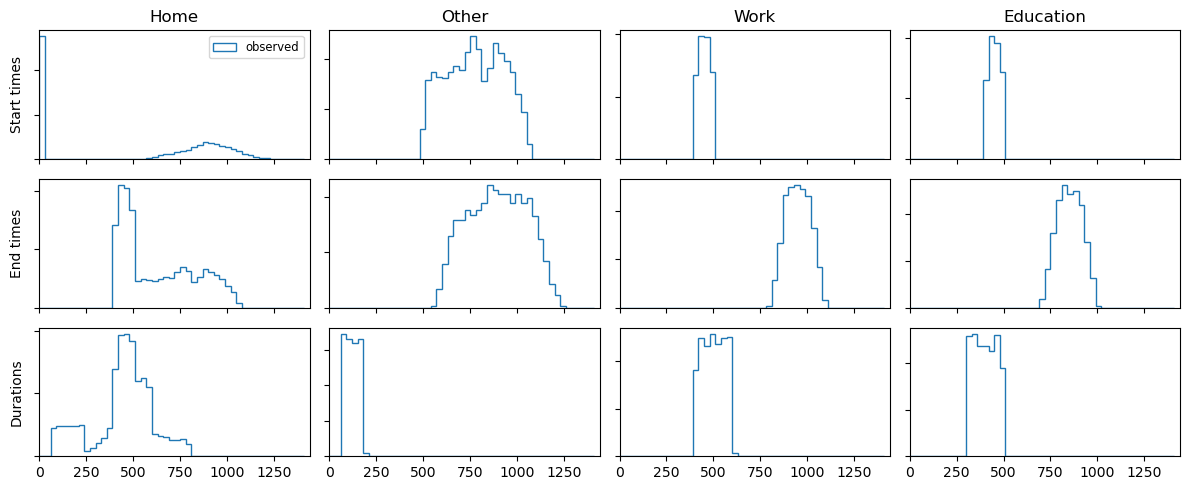

In [24]:
_ = times_distributions_plot(schedules, ys={})

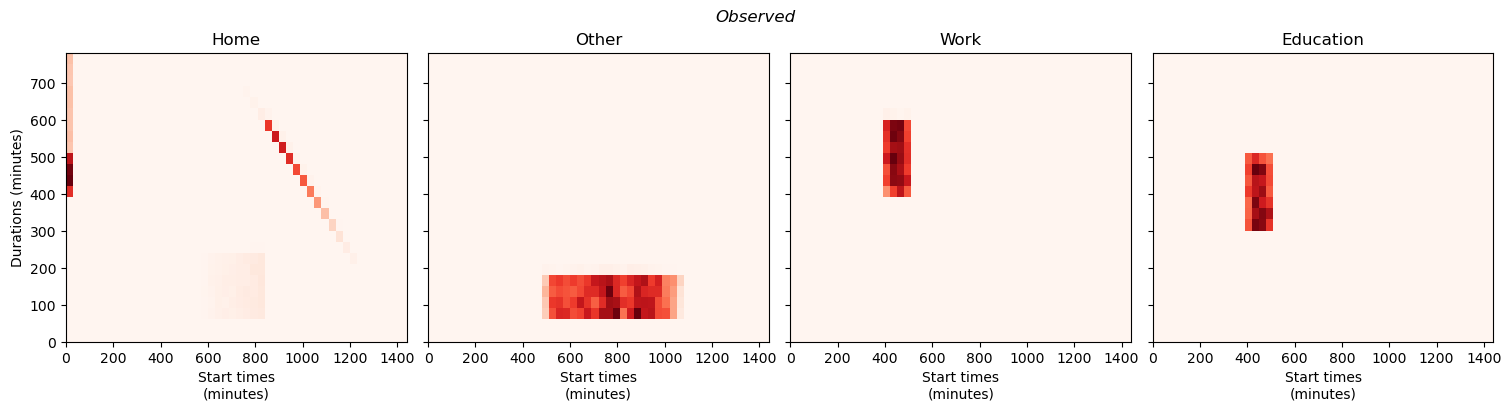

In [25]:
_ = joint_time_distributions_plot(schedules, ys={})

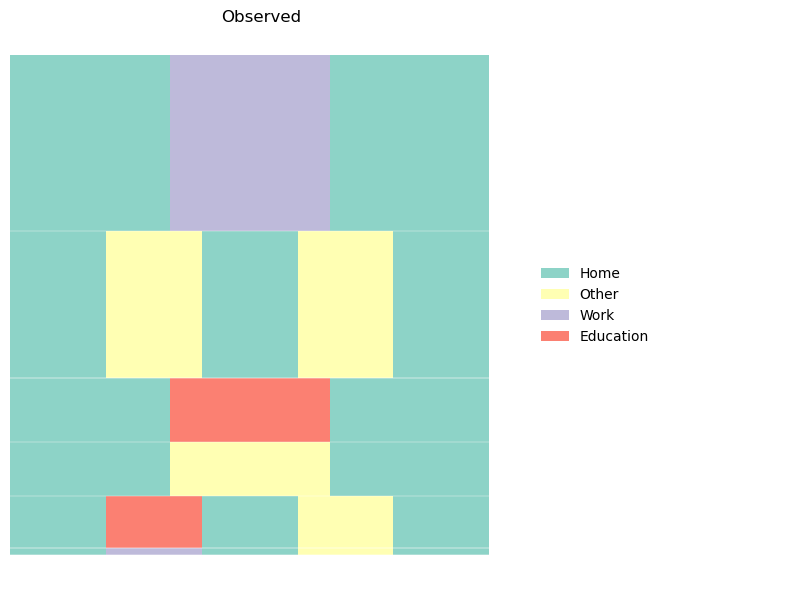

In [26]:
_ = sequence_prob_plot(schedules, ys={}, figsize=(8, 6))